# Entraînement du modèle dans un Pipeline avec préparation automatisé des données

In [2]:
# -----------------------------------------------------
# IMPORTS
# -----------------------------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# -----------------------------------------------------
# CHARGER LE DATASET
# -----------------------------------------------------
df = pd.read_csv("../data/dataset_risque_defaut.csv")

# -----------------------------------------------------
# IDENTIFIER LES COLONNES
# -----------------------------------------------------
colonnes_categorielle = ['sexe', 'situation_familiale', 'type_contrat_travail', 'type_credit']
colonnes_numeriques = [col for col in df.columns if col not in colonnes_categorielle + ['defaut']]

# -----------------------------------------------------
# SÉPARATION X / y
# -----------------------------------------------------
X = df.drop(columns=['defaut'])
y = df['defaut']

# -----------------------------------------------------
# SPLIT TRAIN / TEST
# -----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------------------------
# CONSTRUCTION DU PREPROCESSING : ColumnTransformer
# -----------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(drop='first'), colonnes_categorielle),
        ('numerical', StandardScaler(), colonnes_numeriques)
    ]
)

# -----------------------------------------------------
# PIPELINE COMPLET : Preprocessing → SMOTE → Modèle
# -----------------------------------------------------
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=1000))
])

# -----------------------------------------------------
# ENTRAÎNEMENT
# -----------------------------------------------------
pipeline.fit(X_train, y_train)

# -----------------------------------------------------
# PREDICTION ET SCORE
# -----------------------------------------------------
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy du modèle :", accuracy)


Accuracy du modèle : 0.902


## Évaluation complète du modèle

### 1. Courbe ROC + l’AUC

AUC du modèle : 0.9766414141414141


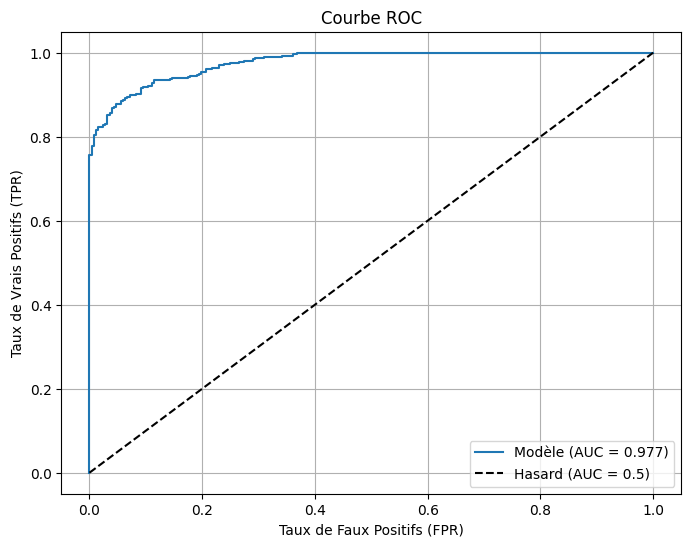

In [3]:
# ------------------------------------------------------
# Courbe ROC + AUC pour ton modèle
# ------------------------------------------------------

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1) Obtenir les probabilités que le client soit en défaut
# predict_proba() retourne 2 colonnes :
# - col 0 = probabilité d'être classé comme 0
# - col 1 = probabilité d'être classé comme 1 (défaut)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# 2) Calculer les coordonnées de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# 3) Calculer l'AUC
roc_auc = auc(fpr, tpr)

print("AUC du modèle :", roc_auc)

# 4) Tracer la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Modèle (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Hasard (AUC = 0.5)')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### 2. Matrice de confusion + Precision / Recall / F1

In [5]:
from sklearn.metrics import confusion_matrix, classification_report

# 1) Prédictions (classe 0 ou 1)
y_pred = pipeline.predict(X_test)

# 2) Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

print("MATRICE DE CONFUSION :\n")
print(cm)

# 3) Precision / Recall / F1
print("\nMETRIQUES DETAILLEES :\n")
print(classification_report(y_test, y_pred, digits=4))


MATRICE DE CONFUSION :

[[235  17]
 [ 81 667]]

METRIQUES DETAILLEES :

              precision    recall  f1-score   support

           0     0.7437    0.9325    0.8275       252
           1     0.9751    0.8917    0.9316       748

    accuracy                         0.9020      1000
   macro avg     0.8594    0.9121    0.8795      1000
weighted avg     0.9168    0.9020    0.9053      1000



# Optimisation du seuil de décision (Threshold Tuning)

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Probabilités de défaut
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Les seuils à tester
thresholds = [0.5, 0.4, 0.3, 0.2]

results = []

for thr in thresholds:
    print("\n==============================")
    print(f"SEUIL = {thr}")
    print("==============================")
    
    # Convertir la probabilité en classe
    y_pred_thr = (y_probs >= thr).astype(int)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_thr)
    print("Matrice de confusion :")
    print(cm)
    
    # Métriques
    precision = precision_score(y_test, y_pred_thr)
    recall = recall_score(y_test, y_pred_thr)
    f1 = f1_score(y_test, y_pred_thr)
    
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-score  : {f1:.4f}")
    
    # Stockage pour comparaison
    results.append((thr, precision, recall, f1))



SEUIL = 0.5
Matrice de confusion :
[[235  17]
 [ 81 667]]
Precision : 0.9751
Recall    : 0.8917
F1-score  : 0.9316

SEUIL = 0.4
Matrice de confusion :
[[226  26]
 [ 61 687]]
Precision : 0.9635
Recall    : 0.9184
F1-score  : 0.9405

SEUIL = 0.3
Matrice de confusion :
[[217  35]
 [ 49 699]]
Precision : 0.9523
Recall    : 0.9345
F1-score  : 0.9433

SEUIL = 0.2
Matrice de confusion :
[[200  52]
 [ 31 717]]
Precision : 0.9324
Recall    : 0.9586
F1-score  : 0.9453


# Integration du seuil dans le Pipeline et Sauvegarde du modèle

In [7]:
import joblib

# ------------------------------------------------------
# 5.1 : Fonction de prédiction incluant le seuil de 0.3
# ------------------------------------------------------

SEUIL_OPTIMAL = 0.3  # seuil trouvé lors du threshold tuning

def predict_with_threshold(pipeline, X, seuil=SEUIL_OPTIMAL):
    """
    Prédit la classe en utilisant le seuil optimisé.
    Retourne :
    - la classe prédite (0 ou 1)
    - la probabilité de défaut
    """
    proba = pipeline.predict_proba(X)[:, 1]   # probabilité classe 1
    prediction = (proba >= seuil).astype(int) # seuil custom
    return prediction, proba

# ------------------------------------------------------
# 5.2 : Sauvegarde du pipeline et du seuil
# ------------------------------------------------------

# Sauvegarder le pipeline complet entraîné
joblib.dump(pipeline, "../models/modele_risque_defaut.pkl")

# Sauvegarder le seuil optimal séparément
joblib.dump(SEUIL_OPTIMAL, "../models/seuil_optimal.pkl")

print("Modèle et seuil sauvegardés avec succès.")


Modèle et seuil sauvegardés avec succès.
